### Motivation
In a [previous post](http://danielweitzenfeld.github.io/passtheroc/blog/2014/10/28/bayes-premier-league/), I implemented a model of soccer developed by Gianluca Baio and Marta A. Blangiardo.  They model the number of goals each team scores in a game as Poisson distributed with latent scoring intensities a function of each team's attacking strength, defending strength, and a home team advantage.  One output of the model is estimates of every team's attacking and defending strengths, estimates that can be used to predict the outcomes of future games. 

This model had (at least) two weaknesses:
1. By modeling goals scored, it didn't give any credit for almost-goals-that-weren't.  A team got no credit for generating a solid opportunity that would have been a goal if it were not for bad luck.
2. By modeling only the end-of-game goal tallies, it did not take into account the score differential, let alone the evolution of this differential over the course of the game. A team with 3 goals going into the final quarter of a game will put less effort into scoring if their opponents have 0 goals than if their opponents have 2, 3, or 4.

I considered these problems for a while and turned to American football, which is a much more structured and discretized game than soccer. A game can be broken down into drives or possessions, and data is available on the outcome of each drive.  I built a [model](http://danielweitzenfeld.github.io/passtheroc/blog/2015/01/30/bayes-nfl/) of the NFL at the drive level, which addressed both of the weaknesses of the soccer model.  It addressed the first weakness by giving credit for drive progression, even if the drive didn't end in a touchdown.  It addressed the second weakness by using drive-level covariates, such as score differential and time on the clock. 

I then turned back to soccer.  In the meantime, problem #1 had essentially been solved by 'expected goals' or [xG](https://www.sportperformanceanalysis.com/article/what-are-expected-goals-xg).  It was less obvious how to solve the problem #2 with soccer.  Because soccer is a fluid game, the modeling approach doesn't jump out at you the way it might for a discrete possession-based game like football.  

Before diving into the model, I'd like to motivate issue #2 above a bit more.  If we *don't* control for game situation when evaluating team strength using an outcome measure like points, goals or expected goals, we risk biasing our estimates of team strength upward for the weakest teams and downward for the strongest.  This is true across sports.  Imagine a strong team blowing out a weak team in the fourth quarter of an NFL game.  The strong team puts in their B-team, allowing the weak team to score a couple touchdowns.  This result will make the two teams look closer in strength than they really are.  Or in soccer, as described in the 'Criticisms' section of the [xG article](https://www.sportperformanceanalysis.com/article/what-are-expected-goals-xg):

>A team may score one or two difficult chances early in a game and sit back for the remaining of the 90 minutes, allowing their opponents to take many shots from different positions, thus increasing the opponents xG. One could then claim that the losing team achieved a higher xG therefore deserves the win. This is why xG should always be taken with additional context of the game before creating a verdict. 

For this reason, if we want to use xG to evaluate team strength - and to use our strength estimates to predict the outcomes of future games - we need to take game situation into account.  

### The Model
I decided to approach the problem simply - by breaking up a soccer game into segments.  Most segments are 10 minutes long, but the length of the last segment of each half varies depending on injury time.  

In [5]:
SEGMENTS = pd.DataFrame([
    {'segment': 0, 'period': 1, 'start': 0, 'end': 10}, # start and end are minutes
    {'segment': 1, 'period': 1, 'start': 10, 'end': 20},
    {'segment': 2, 'period': 1, 'start': 20, 'end': 30},
    {'segment': 3, 'period': 1, 'start': 30, 'end': 40},
    {'segment': 4, 'period': 1, 'start': 40, 'end': None}, # 40-45 + stoppage
    {'segment': 5, 'period': 2, 'start': 45, 'end': 55},
    {'segment': 6, 'period': 2, 'start': 55, 'end': 65},
    {'segment': 7, 'period': 2, 'start': 65, 'end': 75},
    {'segment': 8, 'period': 2, 'start': 75, 'end': 85},
    {'segment': 9, 'period': 2, 'start': 85, 'end': None} # 45-90 + stoppage
])

I then model the total amount of xG generated by a team in a game *segment* as a function of its attacking strength, the opposing team's defending strength, home team advantage, the segment, and the game situation as of the start of the segment, and an interaction between segment and situation.  The obvious objection is that the game situation may change partway through the segment, rendering the covariates wrong.  I find the model meets its intended purpose despite this weakness.

I graphed a histogram of team xG per game-segment and it looked exponentially distributed, so I modeled observed xG per game segment accordingly: 

$$y_i|\lambda_i \sim Exponential(\lambda_i)$$

To be explicit, $i$ indexes _segments_ of individual games, such that $i=0$ is the first 10 minutes of the first game of the season, $i=9$ is the closing minutes of the same game, $i=10$ is the first 10 minutes of the second game of the season, etc.

For the home team:

$$\lambda_i = intercept * (1/segment\_length_i) * e^{home_{h(i)} + attack_{h(i)} + defend_{a(i)} + segment_i + sitch_i + segment\_sitch_i}$$

All covariates are drawn from hierachial distributions: 


$$home \sim Normal(home\_mean, \sigma_{home})$$
$$home\_mean \sim Normal(-.2, 1)$$
$$\sigma_{home} \sim HalfNormal(.4)$$

$$attack \sim StudentT(0, \sigma_{attack}, \nu_{attack})$$ 
$$\sigma_{attack} \sim HalfNormal(.8)$$
$$\nu_{attack} \sim Gamma(2, .01)$$

$$defense \sim StudentT(0, \sigma_{defense}, \nu_{defense})$$
$$\sigma_{defense} \sim HalfNormal(.8)$$
$$\nu_{defense} \sim Gamma(2, .01)$$

$$segment \sim Normal(0, \sigma_{segment})$$ 
$$\sigma_{segment} \sim HalfNormal(1)$$

$$sitch \sim Normal(0, \sigma_{sitch})$$
$$\sigma_{sitch} \sim HalfNormal(1)$$

$$segment\_sitch \sim Normal(0, \sigma_{segment\_sitch})$$
$$\sigma_{segment\_sitch} \sim HalfNormal(.5)$$

I bucket game situation into 5 buckets, representing the score differential from the attacking team's POV:

In [1]:
def score_differential_to_sitch(x):
    if x < -1:
        return 0
    elif x == -1:
        return 1
    elif x == 0:
        return 2
    elif x == 1:
        return 3
    elif x > 1:
        return 4

I fit the model in `pymc3` using data from the 2017-2018 English Premier League season. 
### Results
The chart below uses the $segment$, $sitch$, and $segmentsitch$ parameters to show the tendency for an average team to generate xG based on game segment and situation, after controlling for team strengths.  I've inverted the parameter signs so that higher values correspond with more xG generation; these are represented by lighter colors. The top half of the chart is lighter than the bottom half because teams that are down tend to generate more xG than those that are up.  Also, the 2nd half of the game is generally lighter than the first, as games tend to "open up" in the 2nd half.  The lightest square corresponds to the closing minutes of a game, for the team down by only one goal.

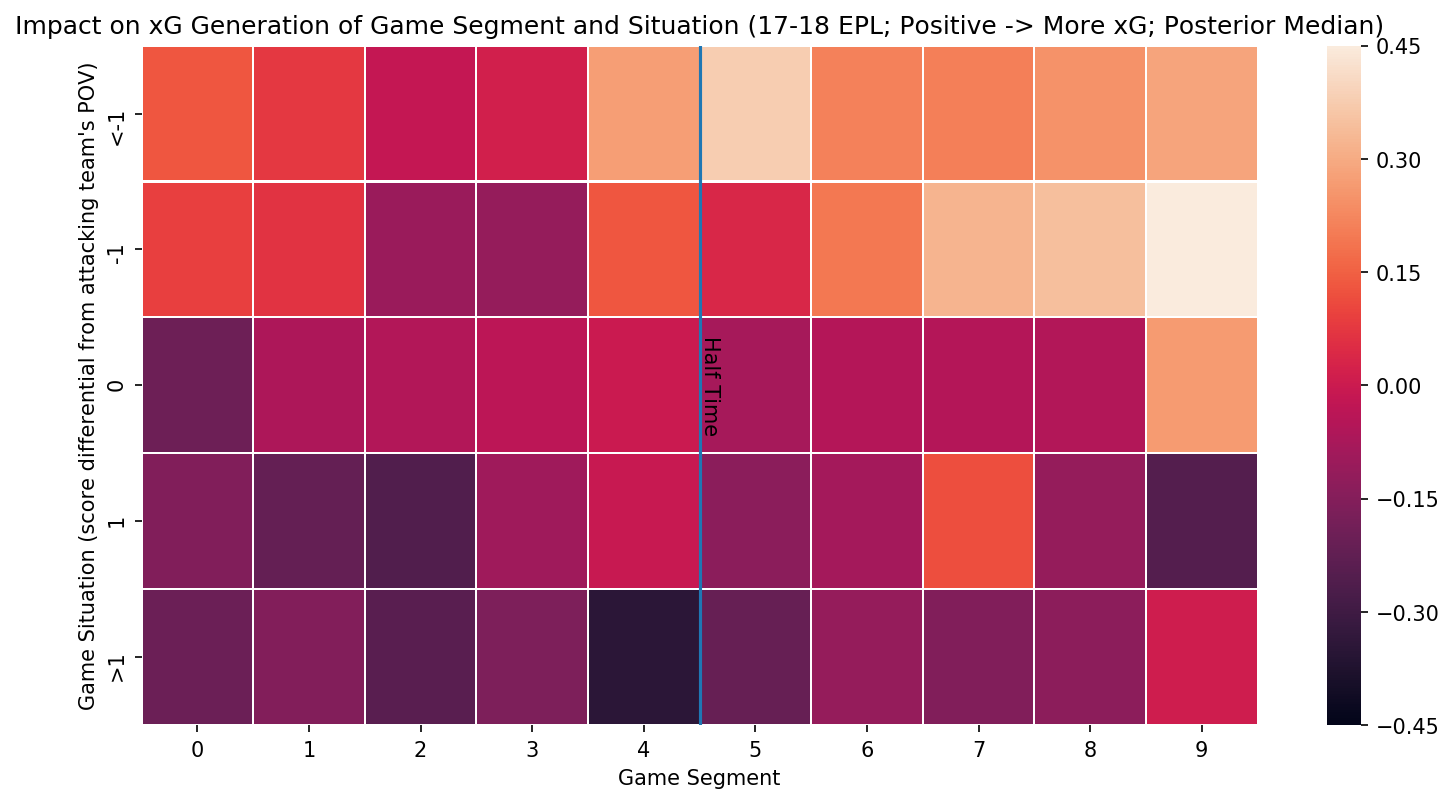

In [5]:
Image(os.path.join(CHART_DIR, 'game_sitch.png'))

And as I mentioned in the motivation section, the danger of ignoring game situation when using xG to evaluate team strength is that you'll get upwardly-biased estimates of the strength of the weakest teams and downwardly-biased estimates of the strength of the strongest teams.  To illustrate, I fit the same model on the same data, but without $segment$, $sitch$ or $segmentsitch$ parameters.  The chart below shows the posterior distributions for the defending strength parameters from the two models. Again, I've inverted the paramater signs so that lower -> stronger xG Suppression. As anticipated, the model that ignores game situation tends to overestimate the strength of the weakest teams and underestimate the strength of the strongest.

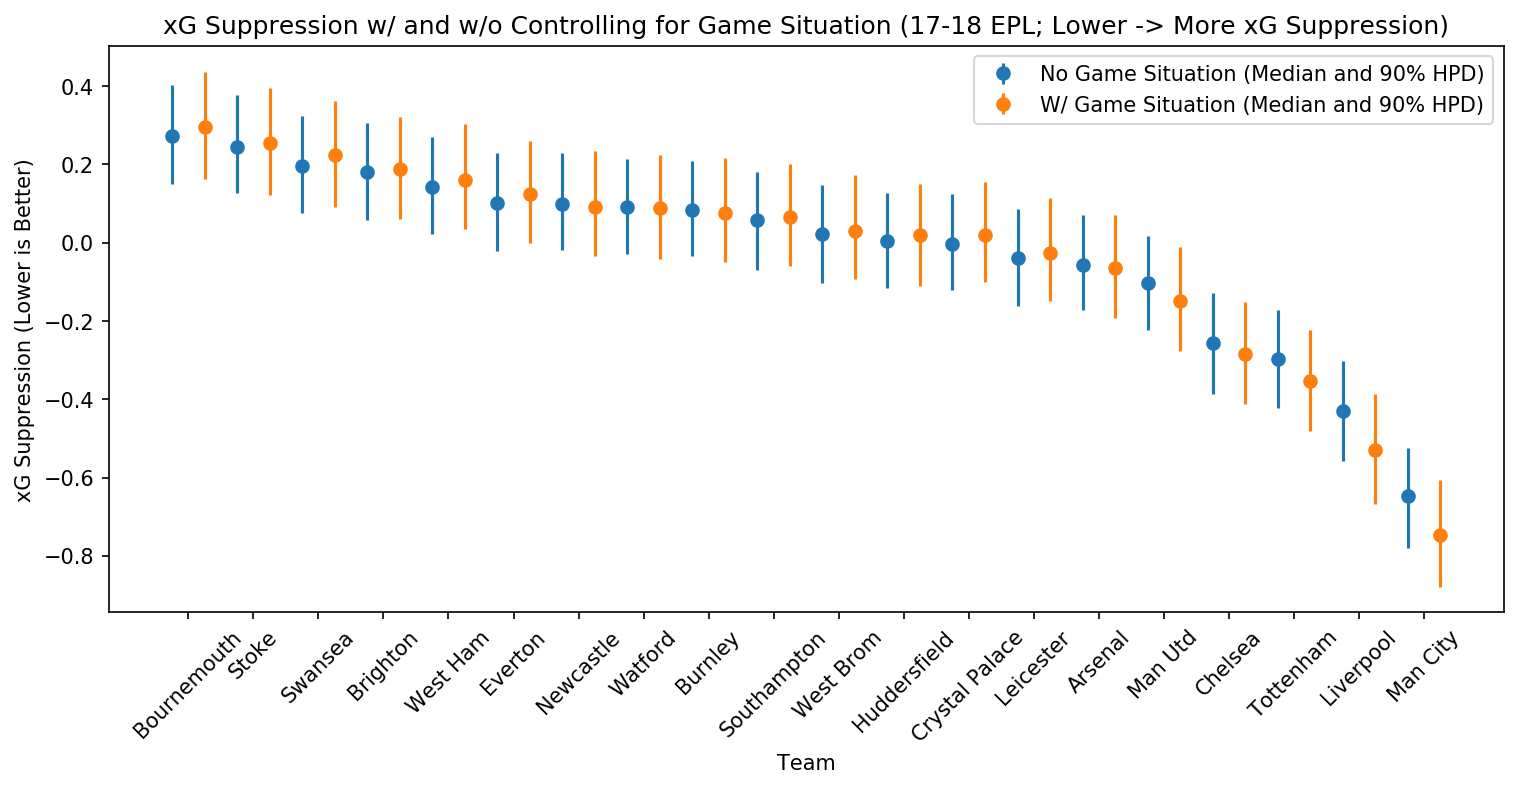

In [6]:
Image(os.path.join(CHART_DIR, 'xg_suppress.png'))

The corresponding chart for attacking strength shows the same phenomenon, but to a lesser degree. 

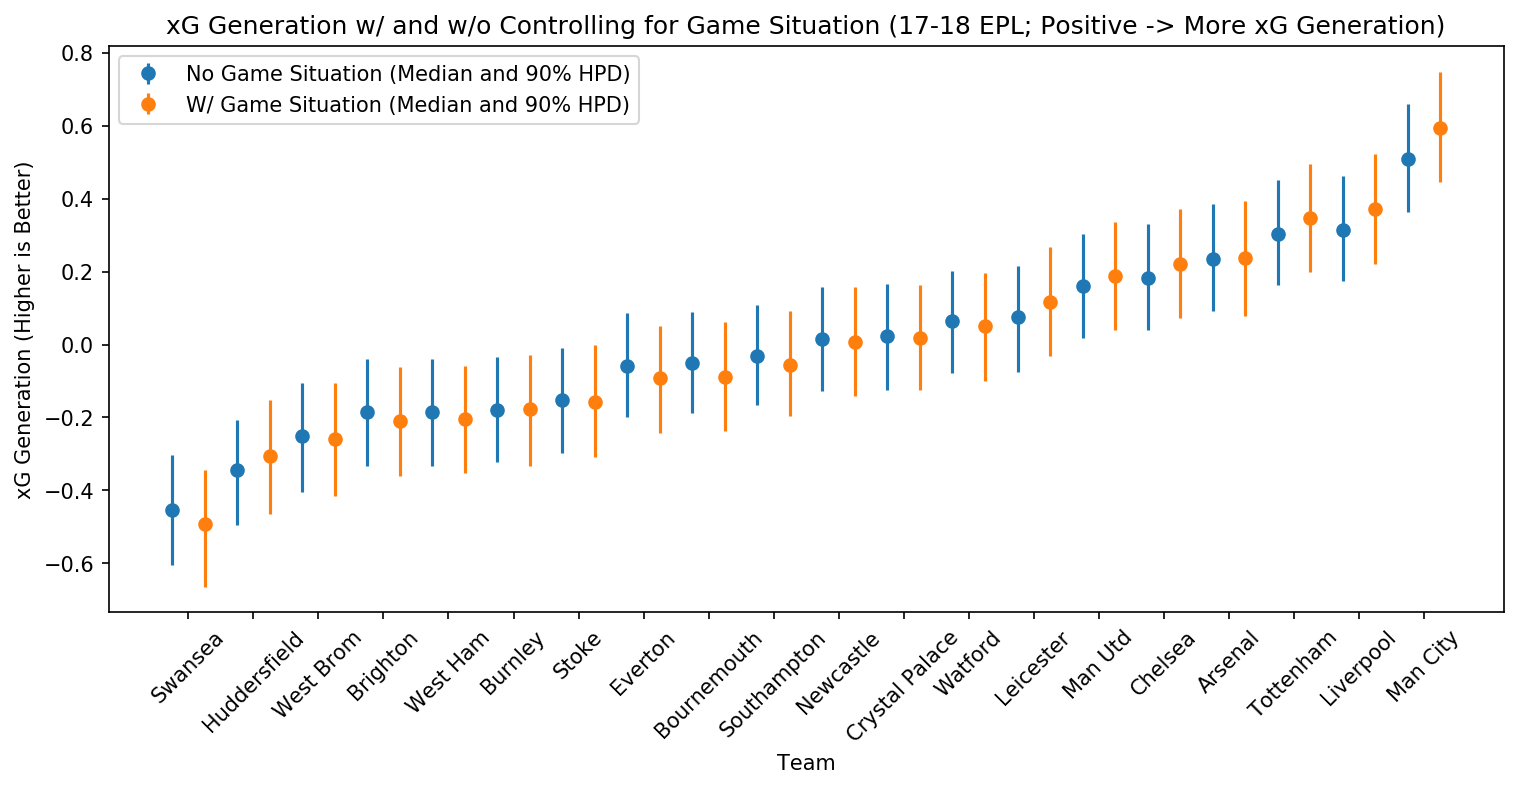

In [7]:
Image(os.path.join(CHART_DIR, 'xg_gen.png'))

### Conclusion
Across sports, when using an effort-based outcome measure like goals, shots, or expected goals to measure team strengths, we need to control for the teams' levels of effort.  We can't measure effort directly, but we can measure the game situation, which determines effort level.  Indeed, we could add covariates to this model that also help determine effort level, such as whether the game was a must-win to avoid relegation.
When we don't control for effort, we risk underestimating the strength of the strongest teams because the strongest teams often find themselves in situations where they don't need to give 100%.  Similarly, we risk overestimating the strength of the weakest, because they are often in situations where their opponents aren't giving 100%.